In [1]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Disable warinings
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import librosa
from matplotlib import pyplot as plt
from IPython.display import Audio


# Display physical divices (ensure GPU is available to tensorflow)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Extract RAVDESS Dataset

data_files = os.listdir("data")
print(data_files)
if "RAVDESS" not in data_files:
    print("need to unzip")
    ravdess_path = "/data/" + data_files[0]
    import zipfile
    with zipfile.ZipFile("data/" + "RAVDESS.zip", 'r') as zip_ref:
        print("unzipping....")
        zip_ref.extractall("data/RAVDESS")
    print("Extraction Complete")

['.ipynb_checkpoints', 'RAVDESS', 'RAVDESS.zip']


In [3]:
# Data Preparation -- RAVDESS

# Import file information
path_RAVDESS = "data/RAVDESS/"
directory_list_RAVDESS = os.listdir(path_RAVDESS)
df_RAVDESS = pd.DataFrame(columns=['modality', 'vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'file_path'])
for actor in directory_list_RAVDESS:
    actor_directory = os.listdir(path_RAVDESS+actor)    
    for file in actor_directory:
        identifiers = file.split('.')[0].split('-')
        identifiers.append(path_RAVDESS + actor + '/' + file) # append the file_path
        df_RAVDESS.loc[len(df_RAVDESS.index)] = identifiers

# translate filename identifiers
modality_RAVDESS = {'01':'full-AV', '02':'video-only', '03':'audio-only'}
vocal_channel_RAVDESS = {'01':'speech', '02':'song'}
emotion_RAVDESS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
emotional_intensity_RAVDESS = {'01':'normal', '02':'strong'}
statement_RAVDESS = {'01': "Kids are talking by the door", '02':"Dogs are sitting by the door"}

df_RAVDESS['modality'] = df_RAVDESS.modality.replace(modality_RAVDESS)
df_RAVDESS['vocal_channel'] = df_RAVDESS.vocal_channel.replace(vocal_channel_RAVDESS)
df_RAVDESS['emotion'] = df_RAVDESS.emotion.replace(emotion_RAVDESS)
df_RAVDESS['emotional_intensity'] = df_RAVDESS.emotional_intensity.replace(emotional_intensity_RAVDESS)
df_RAVDESS['statement'] = df_RAVDESS.statement.replace(statement_RAVDESS)
df_RAVDESS['repetition'] = df_RAVDESS['repetition'].astype(int)
df_RAVDESS['actor'] = df_RAVDESS['actor'].astype(int)
# set gender column
df_RAVDESS['gender'] = df_RAVDESS.actor.apply(lambda actor: 'male' if actor % 2 == 1 else 'female')

print(df_RAVDESS.info())
# print(df_RAVDESS.groupby(['emotion']).gender.value_counts())
df_RAVDESS.head()


<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1439
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   modality             1440 non-null   object
 1   vocal_channel        1440 non-null   object
 2   emotion              1440 non-null   object
 3   emotional_intensity  1440 non-null   object
 4   statement            1440 non-null   object
 5   repetition           1440 non-null   int64 
 6   actor                1440 non-null   int64 
 7   file_path            1440 non-null   object
 8   gender               1440 non-null   object
dtypes: int64(2), object(7)
memory usage: 112.5+ KB
None


,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,file_path,gender
0,audio-only,speech,neutral,normal,Kids are talking by the door,1,1,data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav,male
1,audio-only,speech,neutral,normal,Kids are talking by the door,2,1,data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav,male
2,audio-only,speech,neutral,normal,Dogs are sitting by the door,1,1,data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav,male
3,audio-only,speech,neutral,normal,Dogs are sitting by the door,2,1,data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav,male
4,audio-only,speech,calm,normal,Kids are talking by the door,1,1,data/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav,male


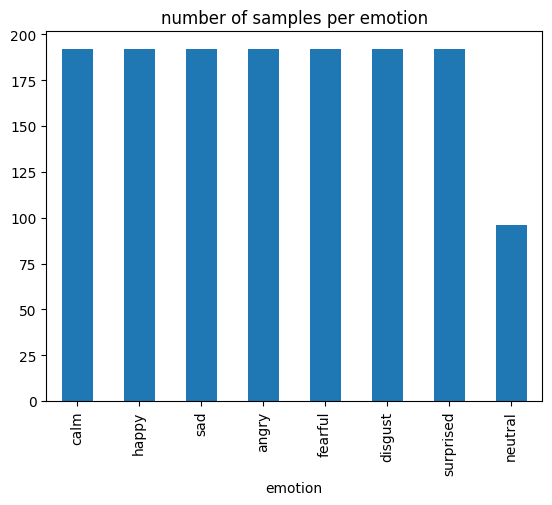

,file_path,emotion
0,data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav,neutral
1,data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav,neutral
2,data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav,neutral
3,data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav,neutral
4,data/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav,calm


In [4]:
# Combining data sources for our use

df = pd.concat([df_RAVDESS[['file_path', 'emotion']]])

# Plot number of samples per emotion
df['emotion'].value_counts().plot(kind='bar')
plt.title("number of samples per emotion")
plt.show()
df.head()

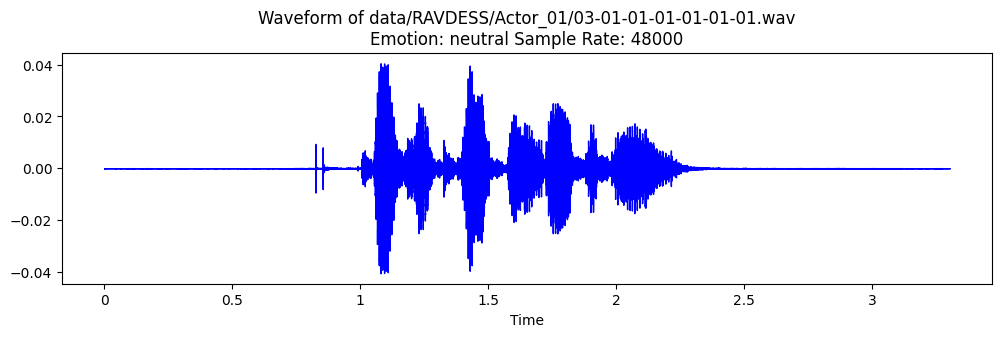

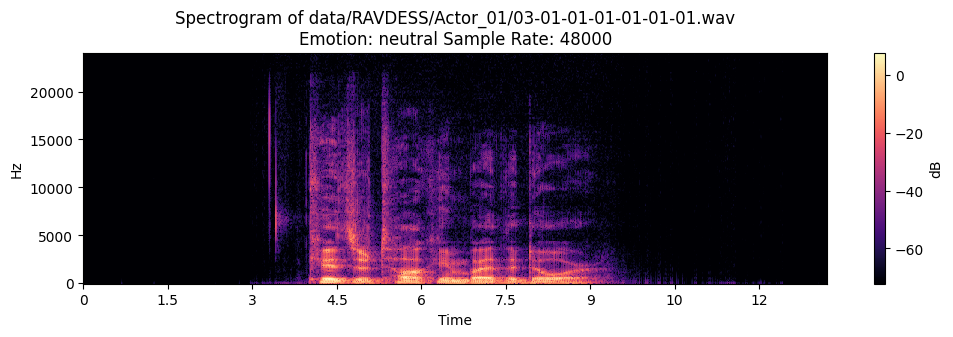

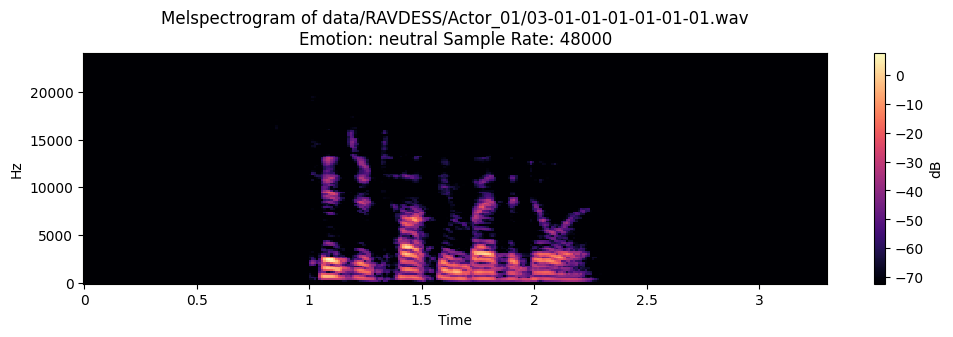

In [5]:
# Visualizing Data

def show_waveform(data, sr, path, emotion):
    plt.figure(figsize=(12, 3))
    plt.title(f"Waveform of {path}\nEmotion: {emotion} Sample Rate: {sr}")
    librosa.display.waveshow(data, sr=sample_rate, color='blue')
    plt.show()

def show_spectrogram(data, sr, path, emotion):
    spectrogram_ampl = abs(librosa.stft(data, n_fft=512))
    spectrogram_dB = librosa.amplitude_to_db(spectrogram_ampl)
    plt.figure(figsize=(12,3))
    plt.title(f"Spectrogram of {path}\nEmotion: {emotion} Sample Rate: {sr}")
    librosa.display.specshow(spectrogram_dB, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(label="dB")
    plt.show()
    # plt.savefig("spectrogram.png")

def show_melspectrogram(data, sr, path, emotion):
    melspec = librosa.feature.melspectrogram(y=data, sr=sr)
    melspec = librosa.amplitude_to_db(melspec)
    plt.figure(figsize=(12,3))
    plt.title(f"Melspectrogram of {path}\nEmotion: {emotion} Sample Rate: {sr}")
    librosa.display.specshow(melspec, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(label="dB")
    plt.show()
    # plt.savefig("melspectrogram.png")
    
emotion = 'neutral'
path = np.array(df.file_path[df.emotion==emotion])[0]

# load audio data with librosa (running into issues importing with tf.audio on some files)
data, sample_rate = librosa.load(path, sr=48000)

# Plot waveforms and spectrogram of data
show_waveform(data, sample_rate, path, emotion)
show_spectrogram(data, sample_rate, path, emotion)
show_melspectrogram(data, sample_rate, path, emotion)

# Provide audio player to playback audio file
Audio(path)


In [6]:
# Load audio data from file, extract Mel-Frequencey Cepstral Coefficients (MFCCs), pair with label (emotion)
DATA = []
max_length = 0
for row in df.iterrows():
    # print(row)
    file_path = row[1].iloc[0]
    emotion = row[1].iloc[1]
    data, sr = librosa.load(file_path, sr=48000)
    MFCCs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=128).T
    DATA.append((MFCCs, emotion))
    # print(MFCCs.shape)
    max_length = max(max_length, MFCCs.shape[0])

In [7]:
# data, sr = librosa.load(df.file_path[0], sr=48000)
# print(data.shape)
# MFCCs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=128)
# print(MFCCs.shape)

In [8]:
# padding data to uniform length https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size

def padding(array, xx, yy):
    h = array.shape[0]
    w = array.shape[1]
    a = (xx-h) // 2
    aa = xx - a - h
    b = (yy - w) //2
    bb = yy - b - w
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode = 'constant')
    
for i in range(len(DATA)):
    DATA[i] = padding(DATA[i][0], max_length, 128), DATA[i][1]    

Number of entries in Training Dataset: ((1080, 495, 128), (1080, 8))
Number of entries in Test Dataset: ((360, 495, 128), (360, 8))


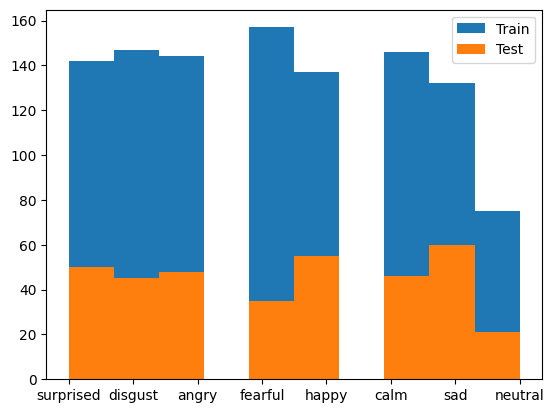

In [9]:
# Prepare data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# print(DATA)
features, labels = zip(*DATA)
features = np.asarray(features)
labels = np.array(labels).reshape((-1, 1))

# Split training/test data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

# create tensorflow datasets
# train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
plt.hist(train_labels, label="Train")
plt.hist(test_labels, label="Test")
plt.legend()

# Scale the training and testing data
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
test_features = scaler.transform(test_features.reshape(-1, test_features.shape[-1])).reshape(test_features.shape)

# one-hot encode the emotion labels
train_labels = OneHotEncoder().fit_transform(train_labels).toarray()
test_labels = OneHotEncoder().fit_transform(test_labels).toarray()

print(f'Number of entries in Training Dataset: {train_features.shape, train_labels.shape}')
print(f'Number of entries in Test Dataset: {test_features.shape, test_labels.shape}')

In [10]:
# Build the Models

batch_size = 10
num_epochs = 50
num_hidden_1 = 500
# num_hidden_2 = 50
val_split = 0.3
reduce_lr_on_plateau_factor = 0.1
reduce_lr_on_plateau_patience = 5

model_LSTM = keras.models.Sequential()
model_GRU = keras.models.Sequential()
model_SRNN = keras.models.Sequential()

# LSTM - Long Short Term Memory
model_LSTM.name = "LSTM"
model_LSTM.add(keras.Input(shape=(128, 495)))
model_LSTM.add(keras.layers.LSTM(num_hidden_1, return_sequences=True))
# model_LSTM.add(keras.layers.LSTM(num_hidden_2, return_sequences=True))
model_LSTM.add(keras.layers.GlobalAveragePooling1D())
model_LSTM.add(keras.layers.Dense(8, activation='sigmoid'))
model_LSTM.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model_LSTM.summary()
lstm_history = model_LSTM.fit(train_features, train_labels, epochs=num_epochs,
                              batch_size=batch_size, validation_split=val_split, 
                              callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                                           factor=reduce_lr_on_plateau_factor, patience=reduce_lr_on_plateau_patience)])
# GRU - Gated Recurrent Units
model_GRU.name = "GRU"
model_GRU.add(keras.Input(shape=(128, 495)))
model_GRU.add(keras.layers.GRU(num_hidden_1, return_sequences=True))
# model_GRU.add(keras.layers.GRU(num_hidden_2, return_sequences=True))
model_GRU.add(keras.layers.GlobalAveragePooling1D())
model_GRU.add(keras.layers.Dense(8, activation='sigmoid'))
model_GRU.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model_GRU.summary()
gru_history = model_GRU.fit(train_features, train_labels, epochs=num_epochs,
                              batch_size=batch_size, validation_split=val_split, 
                              callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                                           factor=reduce_lr_on_plateau_factor, patience=reduce_lr_on_plateau_patience)])

# # SRNN - Simple Recurrent Neural Network
# model_SRNN.name = "SimpleRNN"
# model_SRNN.add(keras.Input(shape=(256, 495)))
# model_SRNN.add(keras.layers.SimpleRNN(num_hidden_1, return_sequences=True))
# # model_SRNN.add(keras.layers.SimpleRNN(num_hidden_2, return_sequences=True))
# model_SRNN.add(keras.layers.GlobalAveragePooling1D())
# model_SRNN.add(keras.layers.Dense(8, activation='sigmoid'))
# model_SRNN.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# model_SRNN.summary()
# srnn_history = model_SRNN.fit(train_features, train_labels, epochs=num_epochs,
#                               batch_size=batch_size, validation_split=val_split, 
#                               callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
#                                                                            factor=reduce_lr_on_plateau_factor, patience=reduce_lr_on_plateau_patience)])

# Test our Models against the Test Data
test_loss_LSTM, test_acc_LSTM = model_LSTM.evaluate(test_features, test_labels)
print("LSTM -- test loss, test acc:", test_loss_LSTM, test_acc_LSTM)

test_loss_GRU, test_acc_GRU = model_GRU.evaluate(test_features, test_labels)
print("GRU -- test loss, test acc:", test_loss_GRU, test_acc_GRU)

# results_SRNN = model_GRU.evaluate(test_features, test_labels)
# print("SimpleRNN -- test loss, test acc:", results_SRNN)

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128, 500)       │     1,992,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 500)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         4,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,996,008 (7.61 MB)

 Trainable params: 1,996,008 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.2695 - loss: 1.9398 - val_accuracy: 0.3735 - val_loss: 1.7574 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4457 - loss: 1.5847 - val_accuracy: 0.4043 - val_loss: 1.5931 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.5623 - loss: 1.3262 - val_accuracy: 0.4537 - val_loss: 1.5225 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.6490 - loss: 1.0526 - val_accuracy: 0.4444 - val_loss: 1.4873 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.6389 - loss: 0.9334 - val_accuracy: 0.4969 - val_loss: 1.3670 - learning_rate: 0.0010
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7300 - loss: 0.8404 - val_accuracy: 0.4414 - val_loss: 1.4510 - learning_rate: 0.0010
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.7501 - loss: 0.7907 - val_acc

Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128, 500)       │     1,495,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 500)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,499,508 (5.72 MB)

 Trainable params: 1,499,508 (5.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.2424 - loss: 1.9312 - val_accuracy: 0.3642 - val_loss: 1.6850 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.4901 - loss: 1.5007 - val_accuracy: 0.4074 - val_loss: 1.5882 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.5646 - loss: 1.2295 - val_accuracy: 0.5185 - val_loss: 1.2973 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.6790 - loss: 0.9589 - val_accuracy: 0.5093 - val_loss: 1.3974 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.7711 - loss: 0.7363 - val_accuracy: 0.5432 - val_loss: 1.3459 - learning_rate: 0.0010
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8636 - loss: 0.4652 - val_accuracy: 0.4815 - val_loss: 1.5170 - learning_rate: 0.0010
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9179 - loss: 0.2879 - val_acc

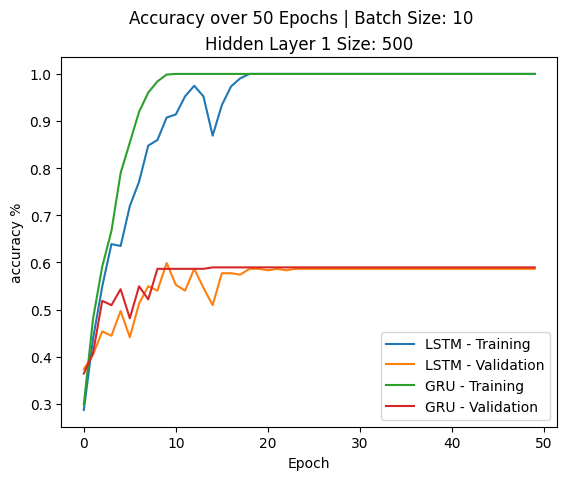

In [14]:
# plotting accuracy over time
# plt.plot(1/8, label='Random Guess')
plt.plot(lstm_history.history['accuracy'], label='LSTM - Training')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM - Validation')
# plt.plot(test_acc_LSTM, label='LSTM - Test')
plt.plot(gru_history.history['accuracy'], label='GRU - Training')
plt.plot(gru_history.history['val_accuracy'], label='GRU - Validation')
# plt.plot(test_acc_GRU, label='GRU - Test')
# plt.plot(srnn_history.history['accuracy'], label='SimpleRNN - Training')
# plt.plot(srnn_history.history['val_accuracy'], label='SimpleRNN - Validation')
plt.suptitle(f"Accuracy over {num_epochs} Epochs | Batch Size: {batch_size}")
plt.title(f"Hidden Layer 1 Size: {num_hidden_1}")
plt.ylabel("accuracy %")
plt.xlabel("Epoch")
plt.legend()
plt.show()